In [186]:
%pip install -q tensorflow tf_keras tensorflow-hub kagglehub pillow numpy matplotlib 

Note: you may need to restart the kernel to use updated packages.


In [187]:
import warnings
warnings.filterwarnings('ignore')

In [188]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import image_dataset_from_directory, load_img, get_file, img_to_array

In [189]:
import kagglehub

path = kagglehub.dataset_download('kaggleashwin/vehicle-type-recognition')

print(f'Path to dataset files: {path}')

Path to dataset files: C:\Users\sinmo\.cache\kagglehub\datasets\kaggleashwin\vehicle-type-recognition\versions\1


In [190]:
import pathlib
import os

data_dir = pathlib.Path(path) / 'Dataset'
os.listdir(data_dir)

['Bus', 'Car', 'motorcycle', 'Truck']

In [191]:
def count_image(data_dir: pathlib.Path, dirs: list[str], ftypes: set[str]):
    n = 0
    for d in dirs:
        d = data_dir / d
        n += len(list(p.resolve() for p in d.glob('*') if p.suffix.lower() in ftypes))
    return n

count_image(data_dir, ['Bus', 'Car', 'Truck'], {'.jpg', '.jpeg', '.png'})

300

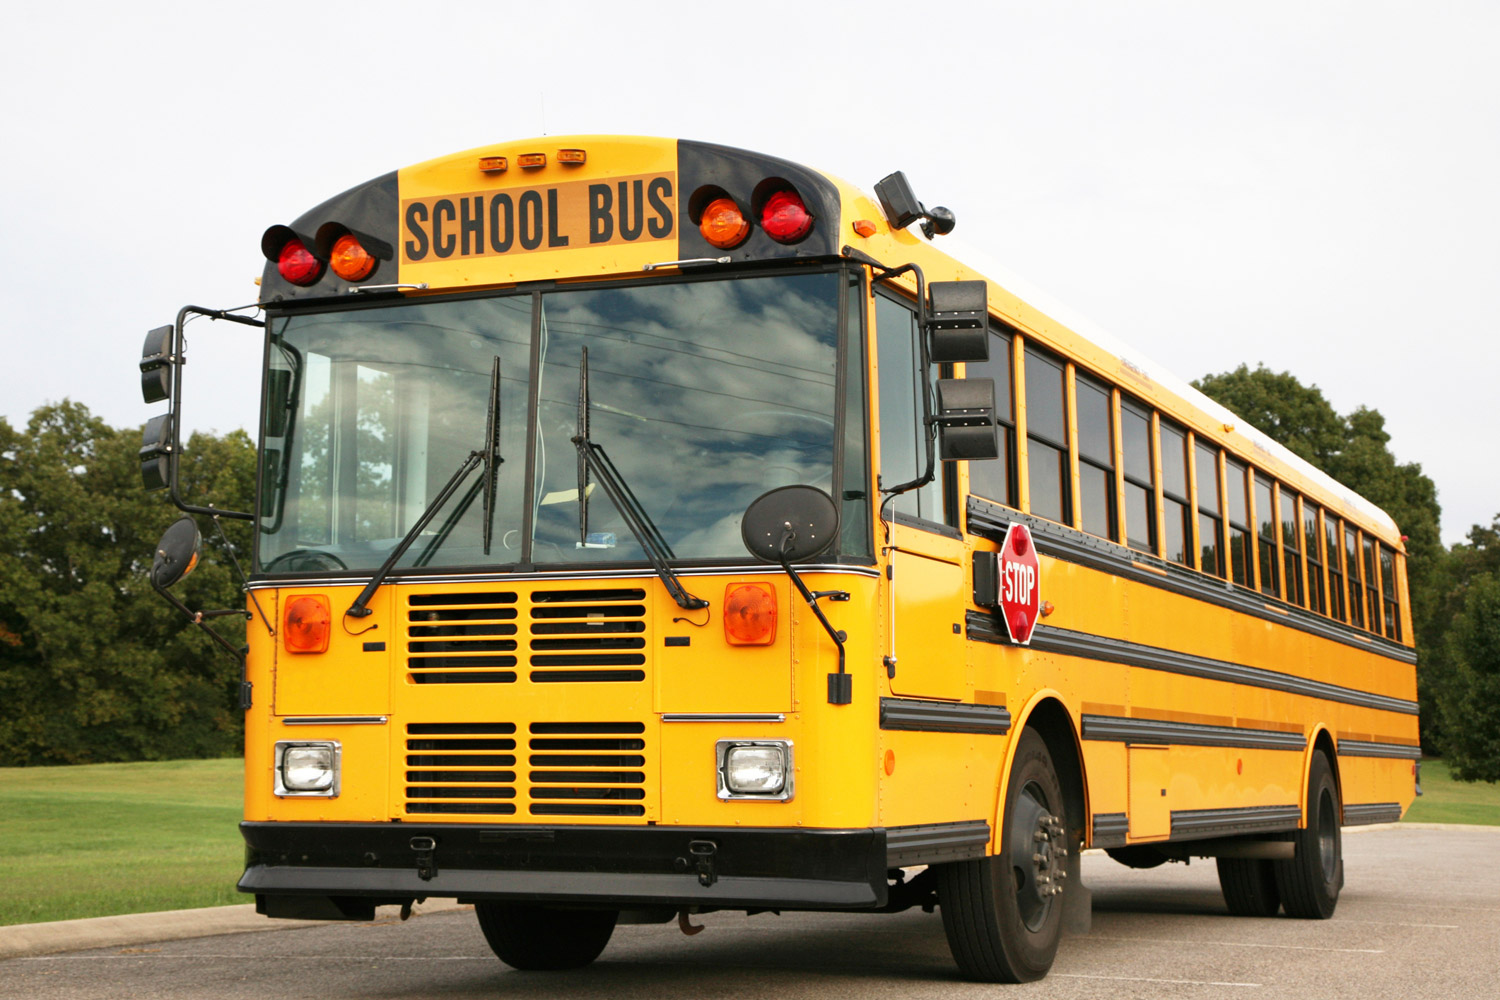

In [192]:
bus = list(data_dir.glob('Bus/*'))
PIL.Image.open(str(bus[0]))

In [232]:
# batch_size = 32
batch_size = 16
img_height = 224
img_width = 224

In [233]:
allowed_folder = ['Bus', 'Car', 'Truck']
train_ds = image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  labels="inferred",
  class_names=allowed_folder,
  batch_size=batch_size)

Found 300 files belonging to 3 classes.
Using 240 files for training.


In [234]:
val_ds = image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  labels="inferred",
  class_names=allowed_folder,
  batch_size=batch_size)

Found 300 files belonging to 3 classes.
Using 60 files for validation.


In [235]:
class_names = train_ds.class_names
print(class_names)

['Bus', 'Car', 'Truck']


In [236]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [237]:
normalization_layer = layers.Rescaling(1./255)

In [238]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [239]:
num_classes = len(class_names)
num_classes

3

In [240]:
data_augmentation = Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

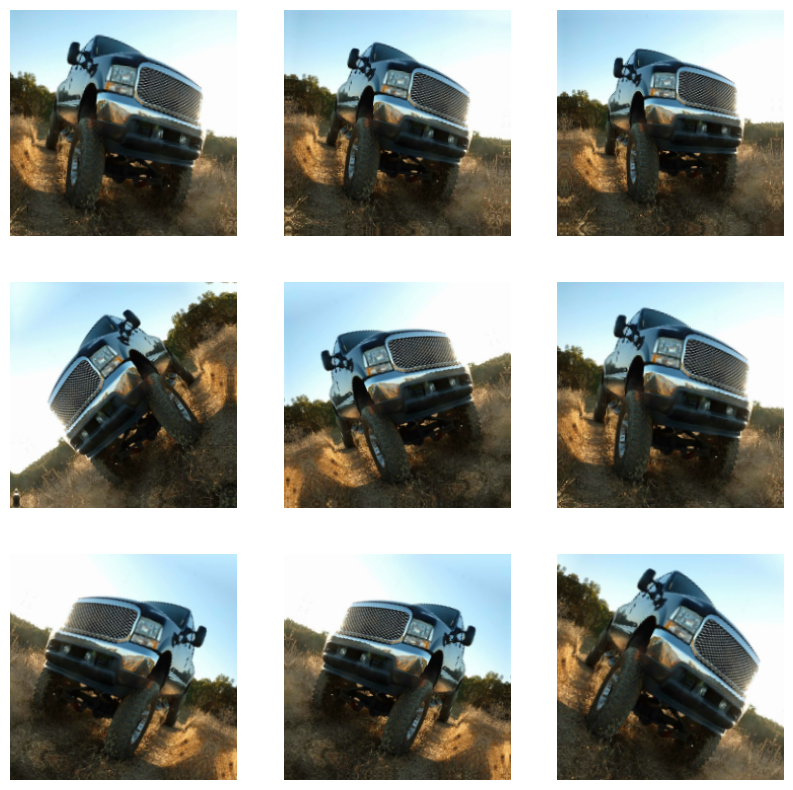

In [241]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")
     

In [242]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.1),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(num_classes, name="outputs", activation='softmax')
])

In [243]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-4
)

In [244]:
base_learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['acc'])

In [245]:
model.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_15 (Sequential)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_16 (Rescaling)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,446,627 (24.59 MB)

 Trainable params: 6,446,627 (24.59 MB)

 Non-trainable params: 0 (0.00 B)

In [246]:
epochs = 18
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[lr_scheduler]
)

Epoch 1/18
15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 722ms/step - acc: 0.3808 - loss: 1.1856 - val_acc: 0.4000 - val_loss: 1.0450 - learning_rate: 0.0010
Epoch 2/18
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 485ms/step - acc: 0.4731 - loss: 1.0404 - val_acc: 0.4833 - val_loss: 1.0916 - learning_rate: 0.0010
Epoch 3/18
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 416ms/step - acc: 0.5812 - loss: 0.9523 - val_acc: 0.5167 - val_loss: 1.1352 - learning_rate: 0.0010
Epoch 4/18
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 400ms/step - acc: 0.6067 - loss: 0.9014 - val_acc: 0.4833 - val_loss: 1.1285 - learning_rate: 0.0010
Epoch 5/18
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 412ms/step - acc: 0.6805 - loss: 0.7862 - val_acc: 0.5667 - val_loss: 1.2158 - learning_rate: 0.0010
Epoch 6/18
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 419ms/step - acc: 0.6960 - loss: 0.7189 - val_acc: 0.5500 - val_loss: 1.3649 - learning_rate: 0.0010
Epoch 7/18
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 446ms/step - acc: 0.7646 - loss: 0.6601 - val_acc: 0.5500 - val_loss: 1.5601 - learning_rate: 5.0000e-04
E

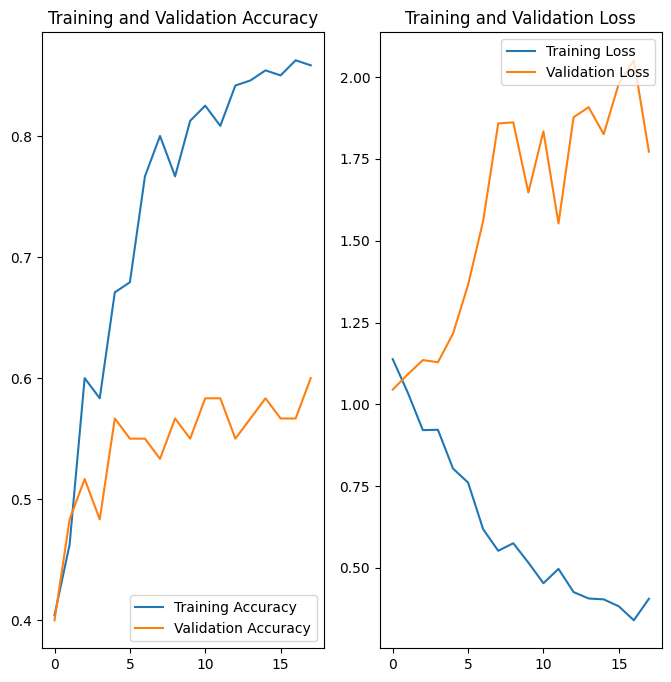

In [247]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [248]:
bus_url = "https://buscdn.cardekho.com/in/ashok-leyland/oyster-tourist-bus/ashok-leyland-oyster-tourist-bus.jpg"
bus_path = get_file('tourist-bus', origin=bus_url)
img = load_img(
    bus_path, target_size=(img_height, img_width)
)
img_array = img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
This image most likely belongs to Bus with a 47.30 percent confidence.


In [249]:
count = len(os.listdir('../models/default/'))
model.save(f'../models/default/vehicle_recognition_{count}.keras')

## Pretrained Model using MobileNetV2

In [250]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(
  data_dir,
  validation_split=0.33,
  subset="training",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE,
  labels="inferred",
  class_names=allowed_folder,
  shuffle=True,)

validation_dataset = image_dataset_from_directory(
  data_dir,
  validation_split=0.33,
  subset="validation",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE,
  labels="inferred",
  class_names=allowed_folder,
  shuffle=True,)

Found 300 files belonging to 3 classes.
Using 201 files for training.
Found 300 files belonging to 3 classes.
Using 99 files for validation.


In [251]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 4)
validation_dataset = validation_dataset.skip(val_batches // 4)

In [252]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 3
Number of test batches: 1


In [253]:
class_names = train_dataset.class_names
print(class_names)

['Bus', 'Car', 'Truck']


In [254]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [255]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.1),
  tf.keras.layers.RandomZoom(0.1),
])

In [256]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [257]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [258]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [259]:
base_model.trainable = False

In [260]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [261]:
prediction_layer = tf.keras.layers.Dense(3, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 3)


In [262]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [263]:
model.summary()

Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_26 (InputLayer)     │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_17 (Sequential)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_4 (TrueDivide)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_4 (Subtract)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │         3,843 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,261,827 (8.63 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [264]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['acc'])

In [265]:
initial_epochs = 15

loss0, accuracy0 = model.evaluate(validation_dataset)

3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 316ms/step - acc: 0.2927 - loss: 1.3159


In [266]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.28
initial accuracy: 0.34


In [267]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - acc: 0.3707 - loss: 1.2509 - val_acc: 0.3582 - val_loss: 1.2234
Epoch 2/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 942ms/step - acc: 0.4522 - loss: 1.0729 - val_acc: 0.3731 - val_loss: 1.1711
Epoch 3/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 933ms/step - acc: 0.5203 - loss: 1.0182 - val_acc: 0.3881 - val_loss: 1.1007
Epoch 4/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 951ms/step - acc: 0.4711 - loss: 1.0726 - val_acc: 0.5075 - val_loss: 1.0918
Epoch 5/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - acc: 0.5210 - loss: 0.9645 - val_acc: 0.5373 - val_loss: 1.0229
Epoch 6/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - acc: 0.4935 - loss: 1.0149 - val_acc: 0.5821 - val_loss: 0.9900
Epoch 7/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - acc: 0.5188 - loss: 0.9466 - val_acc: 0.6418 - val_loss: 0.9252
Epoch 8/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - acc: 0.6290 - loss: 0.9158 - val_acc: 0.7313 - val_loss: 0.8334
Epoch 9/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - acc: 0.6095 - loss: 0.8249 - v

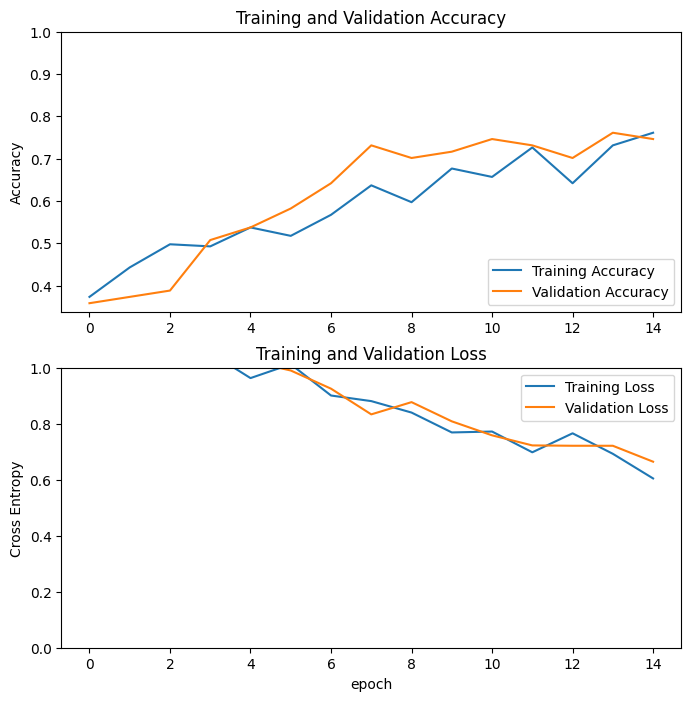

In [268]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()
     

In [269]:
bus_url = "https://buscdn.cardekho.com/in/ashok-leyland/oyster-tourist-bus/ashok-leyland-oyster-tourist-bus.jpg"
bus_path = get_file('tourist-bus', origin=bus_url)
img = load_img(
    bus_path, target_size=IMG_SIZE
)
img_array = img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
This image most likely belongs to Bus with a 45.06 percent confidence.


In [270]:
count = len(os.listdir('../models/pretrained/')) + 1
model.save(f'../models/pretrained/vehicle_recognition_{count}.keras')